In [1]:
# Will be replaced by pip installation
import sys
sys.path.insert(0,"../")

import numpy as np
import matplotlib.pyplot as plt
# for colorbar placement
from mpl_toolkits.axes_grid1 import make_axes_locatable

# To construct rate matrix
from scipy.sparse import issparse, diags

import PyGT

## Load in matrix and vectors selecting $\mathcal{A,B}$ regions using the KTN format

KTN (Kinetic Transition Network) format requires two files:
- `min.data` columns :  $E,\,2S/{\rm k_B},\,D,\,I_x,\,I_y,\,I_z$
- `ts.data`  columns    :  $E,\,2S/{\rm k_B},\,D,\,f,\,i,\,I_x,\,I_y,\,I_z$

where 
- $E$ = Energy
- $S$ = Entropy
- $D$ = Degeneracy
- $I_x$ = $x$-moment of intertia
- $f,i$ = final,initial state indicies

Some technical details:
- `load_ktn()` function looks for files `[min,ts].data` to build KTN, pruning isolated nodes, giving a new node indexing
- `load_ktn_AB()` function looks for files `min.[A,B]` which use the same indicies as the data file
- `retained` is a vector that maps from the unpruned to pruned indexing convention, allowing `min.[A,B]` to be read
- Note that `A_vec, B_vec` can clearly be determined without using `load_ktn_AB()` or `retained`

## For this example we are loading in a 32 state network:

<img src="32state.png" alt="Example KTN" width="400"/>


In [2]:
data_path = "../KTN_data/32state" #LJ38/4k/"
temp = 1.
beta = 1./temp

B, K, tau, N, u, s, Emin, retained = PyGT.io.load_ktn(path=data_path,beta=beta,screen=True)

F = u - s/beta # free energy

pi = np.exp(-beta * F) / np.exp(-beta * F).sum() # stationary distribution

# K has no diagonal entries
if issparse(K):
    Q = K - diags(1.0/tau)
else:
    Q = K - np.diag(1.0/tau)

A_vec, B_vec = PyGT.io.load_ktn_AB(data_path,retained)
I_vec = ~(A_vec+B_vec)
print(f'States in A,I,B: {A_vec.sum(),I_vec.sum(),B_vec.sum()}')

communities = PyGT.io.read_communities(data_path+"/communities.dat",retained,screen=True)
print('\nCommunities file identifies %d macrostates' % len(communities.keys()))


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes

States in A,I,B: (8, 16, 8)
Community 0: 8
Community 1: 8
Community 2: 8
Community 3: 8

Communities file identifies 4 macrostates


# Remove a set of nodes in $\mathcal{I}$ using graph transformation

- We remove all nodes in $\mathcal{I} = (\mathcal{A}\cup\mathcal{B})^\mathsf{c}$ above the 10th percentile in free energy
- See documentation of ` PyGT.tools.choose_nodes_to_remove() ` for other options

In [3]:

rm_vec = PyGT.tools.choose_nodes_to_remove(rm_region=I_vec,
                                              pi=pi,
                                              tau=tau,
                                              style="free_energy",
                                              percent_retained=10
                                             )


gt_B, gt_tau, gt_K = PyGT.GT.blockGT(rm_vec,B,tau,block=10,rates=True,screen=True)



GT BECAME DENSE AT N=32, density=0.136719
GT done in 0.022 seconds with 0 floating point corrections


## Find full MFPT matrix

Calculate the $32 \times 32$ matrix of inter-microstate mean first passage times using GT.

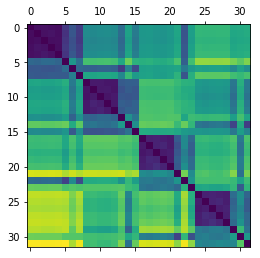

In [12]:
tauM = PyGT.mfpt.full_MFPT_matrix(B,tau,screen=True)
plt.matshow(tauM)

## Find communitity MFPT matrix via full MFPT calculation or metastability approx
Reduced Boltzmann is the same in both cases

In [13]:
#exact weighted-MFPT matrix
c_pi, c_tauM = PyGT.mfpt.community_MFPT_matrix(communities,B,tau,pi,MS_approx=False,screen=True)
#approximate weighted-MFPT matrix
c_pi, c_tauM_approx = PyGT.mfpt.community_MFPT_matrix(communities,B,tau,pi,MS_approx=True,screen=True)
#stationary distribution of macrostates
print(c_pi)
print(c_tauM)
#alternatively, we can compute the weighted-MFPTs from a pre-specified full inter-microstate MFPT matrix
ktn = PyGT.tools.Analyze_KTN(data_path, K=Q.todense(), pi=pi, commdata='communities.dat')
c_tauM_ktn = ktn.get_intercommunity_weighted_MFPTs(tauM)
print(c_tauM_ktn)


[0.31641201 0.19191359 0.25727061 0.23440379]
[[  0.         463.4908166  524.60802635 707.2325798 ]
 [511.6322427    0.         675.54122209 435.79646546]
 [575.5277695  678.31953914   0.         547.48055353]
 [861.79173354 542.2141931  651.11996412   0.        ]]
[[  0.         463.4908166  524.60802635 707.2325798 ]
 [511.6322427    0.         675.54122209 435.79646546]
 [575.5277695  678.31953914   0.         547.48055353]
 [861.79173354 542.2141931  651.11996412   0.        ]]


## Plot ratio of exact to approximate MFPT matrix
Diagonal entries will be set to zero in application, but here we set diagonal terms to unity to avoid errors when taking ratio.

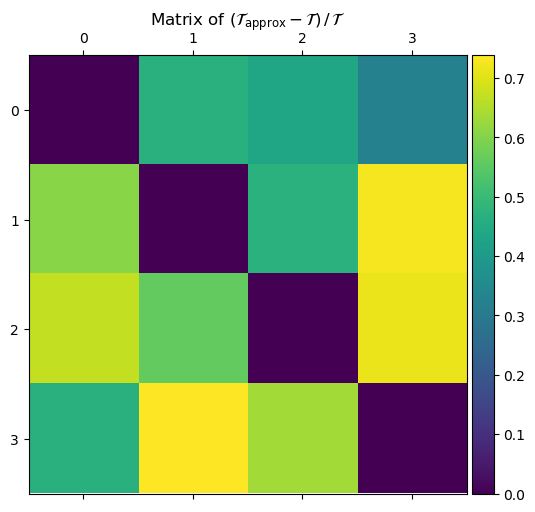

In [14]:
c_tauM += np.eye(c_pi.size) - np.diag(c_tauM) # i.e. remove diagonal and replace with 1
c_tauM_approx += np.eye(c_pi.size) - np.diag(c_tauM_approx) # i.e. remove diagonal and replace with 1

plt.figure(figsize=(6,6),dpi=100)
plt.title(r"Matrix of $(\mathcal{T}_{\rm approx}-\mathcal{T})\,/\,\mathcal{T}$")
ax = plt.gca()
im = ax.matshow((c_tauM_approx-c_tauM)/c_tauM)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


## First passage time distribution between $\mathcal{A}$ and $\mathcal{B}$

MFPT A<-B :  664.5826837564706 878.2798938434964
MFPT B<-A :  585.793406701796 777.2852968888907


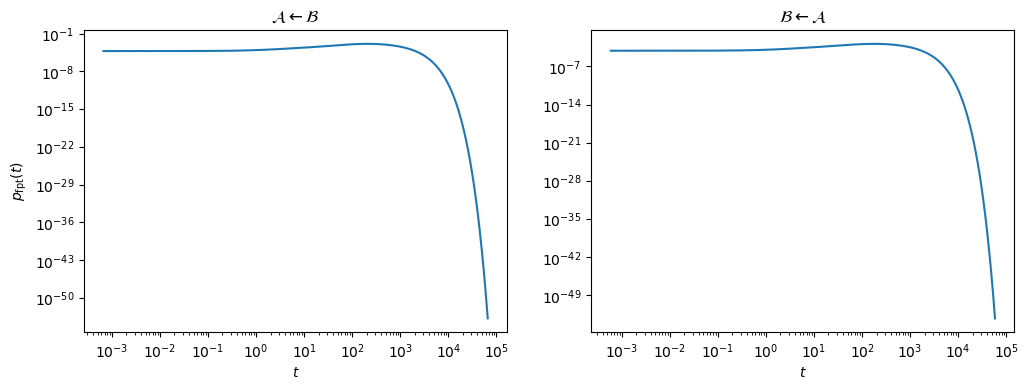

In [15]:

moments, pt = PyGT.stats.compute_passage_stats(A_vec,B_vec,pi,Q,dopdf=True,rt=np.logspace(-6,2,400))

fig,axs = plt.subplots(1,2,figsize=(12,4),dpi=100)

axs[0].loglog(pt[:,0],pt[:,1]/moments[0])
axs[0].set_title(r"$\mathcal{A}\leftarrow\mathcal{B}$")
axs[0].set_ylabel(r"$p_{\rm fpt}(t)$")
axs[0].set_xlabel(r"$t$")
axs[1].loglog(pt[:,2],pt[:,3]/moments[2])
axs[1].set_title(r"$\mathcal{B}\leftarrow\mathcal{A}$")
axs[1].set_xlabel(r"$t$")

print("MFPT A<-B : ",moments[0],np.sqrt(moments[1]))
print("MFPT B<-A : ",moments[2],np.sqrt(moments[3]))



## MFPTs and Phenomenological Rate Constants

Compute the mean first passage time and rates between $\mathcal{A}$ and $\mathcal{B}$.

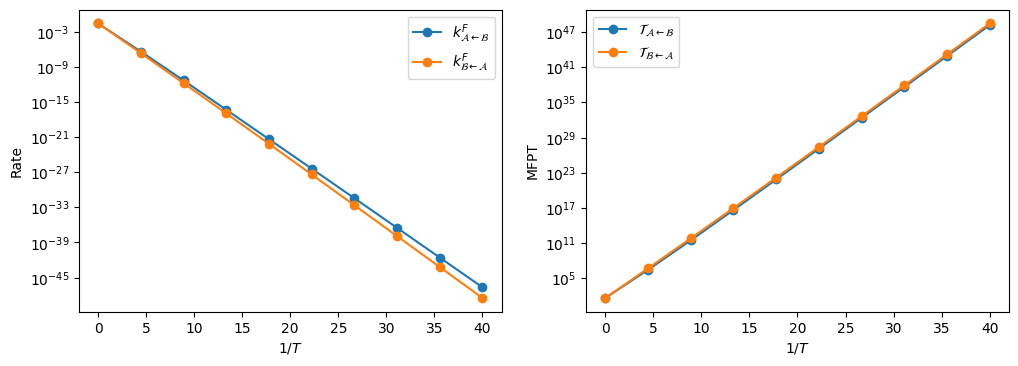

In [4]:
invtemps = np.linspace(0.01, 40, 10)
data = np.zeros((4, len(invtemps)))
for i, beta in enumerate(invtemps):
    B, K, tau, N, u, s, Emin, retained = PyGT.io.load_ktn(path=data_path,beta=beta,screen=False)
    F = u - s/beta # free energy
    pi = np.exp(-beta * F) / np.exp(-beta * F).sum() # stationary distribution
    rates = PyGT.stats.compute_rates(A_vec, B_vec, B, tau, pi, fullGT=False, MFPTonly=False, screen=False)
    data[0,i] = rates['kFAB']
    data[1,i] = rates['kFBA']
    data[2,i] = rates['MFPTAB']
    data[3,i] = rates['MFPTBA']

fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4), dpi=100)
ax.plot(invtemps, data[0,:], '-o', label='$k^F_{\mathcal{A} \leftarrow \mathcal{B}}$')
ax.plot(invtemps, data[1,:], '-o', label='$k^F_{\mathcal{B} \leftarrow \mathcal{A}}$')
ax1.plot(invtemps, data[2,:], '-o', label='$\mathcal{T}_{\mathcal{A} \leftarrow \mathcal{B}}$')
ax1.plot(invtemps,  data[3,:], '-o', label='$\mathcal{T}_{\mathcal{B} \leftarrow \mathcal{A}}$')
ax.set_xlabel('$1/T$')
ax1.set_xlabel('$1/T$')
ax.set_ylabel('Rate')
ax1.set_ylabel('MFPT')
ax.legend()
ax1.legend()
ax.set_yscale('log')
ax1.set_yscale('log')